In [0]:
from ttictoc import TicToc
import numpy as np
import pandas as pd
from bisect import bisect
import matplotlib.pyplot as plt
from tabulate import tabulate
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

In [0]:
# Constants and Inputs Initialization 
Parameters =  {
              "Debt_Marginal" : 277,
              "shares_num" : 232,
              "share_price" : 69.75,
              "rf" : .09,
              "rm" : .055,
              "tax" : .34,
              "beta" : .95,
              "EBIT" : 1388,
              "ind"  : 13,
              "ans_row" : 5
              }

ICR_ratio = [.25, .67, .87, 1.27, 1.57, 1.87, 2.18, 2.76, 3.29, 4.49, 5.65, 6.85, 9.65]      #ascending order
i_rate = [.21, .18, .165, .15, .14, .13, .12, .115, .11, .105, .1025, .1, .097, .093]        #ascending order
#Rating = ['AAA', 'AA', 'A+', 'A', 'A-', 'BBB', 'BB', 'B+', 'B', 'B-', 'CCC', 'CC', 'C', 'D']
Rating = ['D','C','CC','CCC','B-','B','B+','BB','BBB','A-','A','A+','AA','AAA']
dict_rating = dict(zip(Rating, i_rate))   #rating to interest rate dictionary
dict_rate = dict(zip(i_rate, Rating))     #rate to interest rate dictionary

In [0]:
def unlevered_beta(Beta_e, Debt, Equity, Tax):      #compute unlevered beta
  Beta_u = Beta_e / (1 + (Debt/Equity)*(1 - Tax))
  return Beta_u

def CAPM_cost_e(Beta_u, risk_premium, risk_free):   #compute cost of equity by CAPM
  Re = risk_free + Beta_u * risk_premium
  return Re

def equity_beta(Beta_u, DV_ratio, Tax):             #compute equity_beta
  beta_e = Beta_u * (1 + (DV_ratio / (1-DV_ratio))*(1-Tax))
  return beta_e

def ICR_Rating(ind, EBIT, Debt):         #Iteration over matching of default_rating and Interest Cover Ratio
  if Debt==0:
    return dict_rating['AAA'], len(i_rate)-1                         # in case when D/V == 0
  else:
    for k in range(ind,-1,-1):
      ICR = EBIT / (i_rate[k] * Debt)
      temp_rate = i_rate[bisect(ICR_ratio, ICR)]
      if i_rate[k] ==temp_rate:                      # if not match, base on latest Bond Rating to iterate again
        return i_rate[k], k
        break

def WACC_Cal(shares_num, share_price, Debt_Marginal,rf,rm, beta, tax, EBIT, ind, ans_row, N):
  Equity_Total = shares_num * share_price
  Value_Total = Equity_Total + Debt_Marginal
  beta_u = unlevered_beta(beta, Debt_Marginal, Equity_Total, tax)
  answer = np.zeros((ans_row,N))
  for i in np.arange(N):
    D_V_ratio = i/N
    debt = Value_Total * D_V_ratio
    rates, ind = ICR_Rating(ind, EBIT, debt)
    answer[0][i] = D_V_ratio                                                                              #row 1 of answer D/V ratio
    answer[1][i] = equity_beta(beta_u, D_V_ratio, tax)                                                      #row 2 of answer Beta_equity
    answer[2][i] = 100.*CAPM_cost_e(answer[1][i], rm, rf)                                              #row 3 of answer cost of equity
    answer[3][i] = 100.* (rates)                                                                       #row 4 of answer cost of debt
    answer[4][i] = 100.*(D_V_ratio *rates *(1- tax)+(1-D_V_ratio) * answer[2][i]/100)               #row 5 of answer WACC

  df = pd.DataFrame(answer,index=['D/V','Beta', 'Cost of equity(%)', 'Cost of debt(%)', 'WACC(%)'])
  return df

In [4]:
#Answer 1
keys, values = Parameters.keys(), Parameters.values()
Debt_Marginal, shares_num, share_price,rf,rm, tax, beta, EBIT, ind, ans_row = values
data = WACC_Cal(shares_num, share_price, Debt_Marginal,rf,rm, beta, tax,EBIT,ind, ans_row, N=10)
print(tabulate(data, headers=data.columns,tablefmt="github",floatfmt=".2f"))

|                   |     0 |     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9 |
|-------------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| D/V               |  0.00 |  0.10 |  0.20 |  0.30 |  0.40 |  0.50 |  0.60 |  0.70 |  0.80 |  0.90 |
| Beta              |  0.94 |  1.01 |  1.09 |  1.21 |  1.35 |  1.56 |  1.87 |  2.39 |  3.42 |  6.52 |
| Cost of equity(%) | 14.17 | 14.55 | 15.02 | 15.63 | 16.44 | 17.58 | 19.28 | 22.12 | 27.81 | 44.86 |
| Cost of debt(%)   |  9.30 |  9.70 | 10.50 | 11.50 | 13.00 | 15.00 | 15.00 | 16.50 | 18.00 | 18.00 |
| WACC(%)           | 14.17 | 13.73 | 13.40 | 13.22 | 13.30 | 13.74 | 13.65 | 14.26 | 15.07 | 15.18 |


Time spent 0.57 s
Optimal WACC spotted: 15.07 %


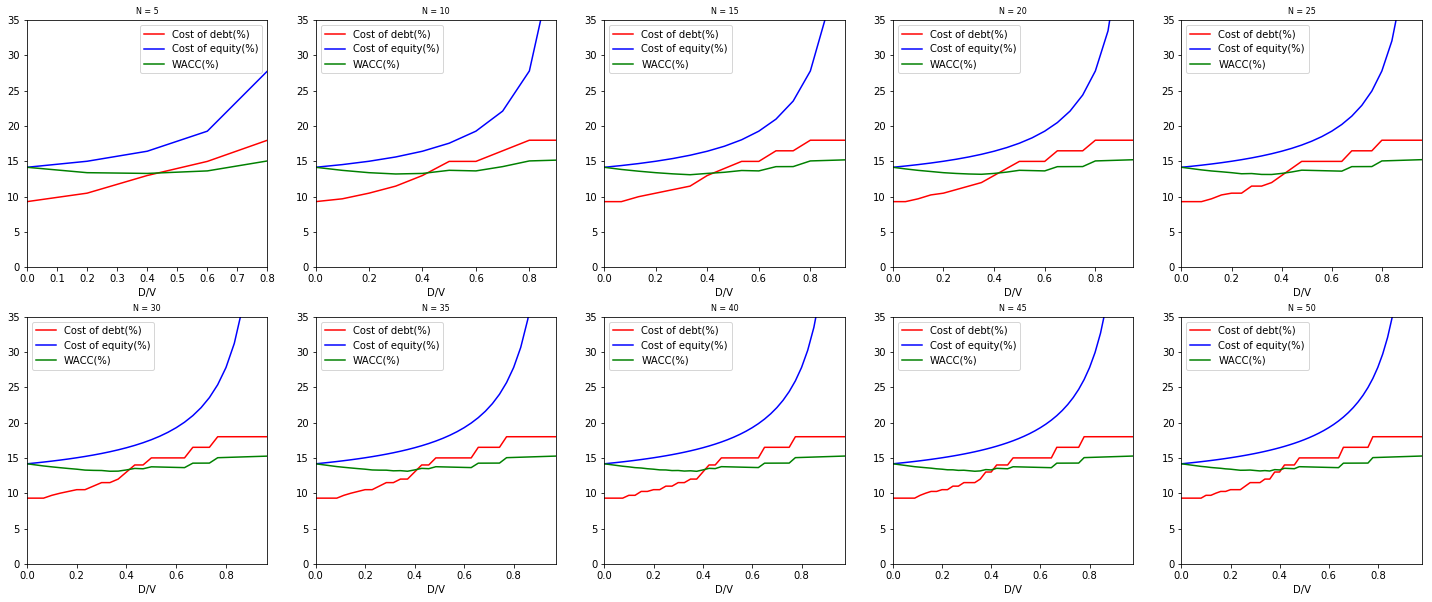

In [5]:
#Exploration on different intervals N=5 to 50
t=TicToc()
t.tic()
fig = plt.figure(figsize=(25,10))
Waccs = []
for num in range(5, 55, 5):
  fig.add_subplot(2,5,(num)/5)
  ax = fig.gca()
  ax.set_ylim([0,35])
  ax.set_title('N = '+str(num), fontdict={'fontsize': 8, 'fontweight': 'medium'})
  data = WACC_Cal(shares_num, share_price, Debt_Marginal,rf,rm, beta, tax,EBIT,ind, ans_row, N=num)
  data.T.plot(kind='line',x='D/V',y='Cost of debt(%)',color='red',ax=ax)
  data.T.plot(kind='line',x='D/V',y='Cost of equity(%)',color='blue', ax=ax)
  data.T.plot(kind='line',x='D/V',y='WACC(%)',color='green', ax=ax)
  Waccs.append(data[4:].max(axis=1).values)
t.toc()
print("Time spent %.2f s"%t.elapsed)
print("Optimal WACC spotted: %.2f %%"%min(np.squeeze(Waccs)))

Time spent 0.79 s
Optimal WACC spotted: 15.07 %


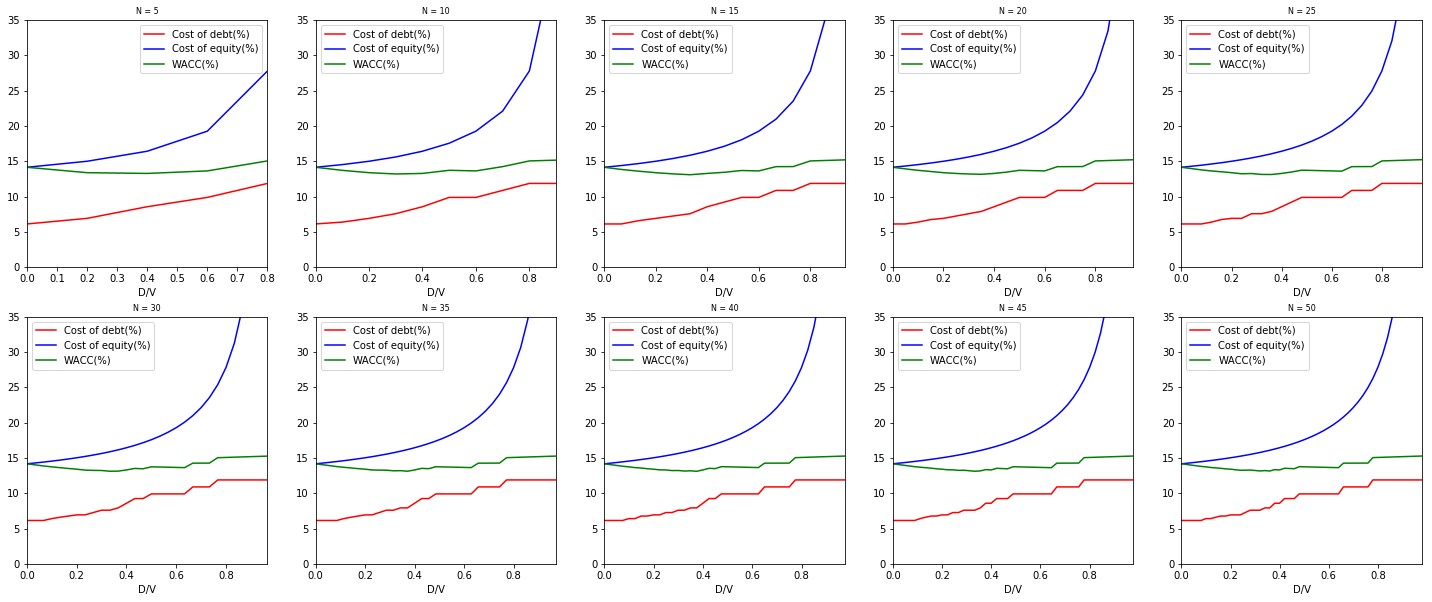

In [6]:
#Exploration on different intervals N=5 to 50, cost of debt(%) * (1-tax)
t=TicToc()
t.tic()
fig = plt.figure(figsize=(25,10))
Waccs = []
for num in range(5, 55, 5):
  fig.add_subplot(2,5,(num)/5)
  ax = fig.gca()
  ax.set_ylim([0,35])
  ax.set_title('N = '+str(num), fontdict={'fontsize': 8, 'fontweight': 'medium'})
  #ax.set_title("mytile", fontdict={'fontsize':8,'fontweight':'medium'})
  data = WACC_Cal(shares_num, share_price, Debt_Marginal,rf,rm, beta, tax,EBIT,ind, ans_row, N=num)
  data[3:4] *=(1-tax)
  data.T.plot(kind='line',x='D/V',y='Cost of debt(%)',color='red',ax=ax)
  data.T.plot(kind='line',x='D/V',y='Cost of equity(%)',color='blue', ax=ax)
  data.T.plot(kind='line',x='D/V',y='WACC(%)',color='green', ax=ax)
  Waccs.append(data[4:].max(axis=1).values)
t.toc()
print("Time spent %.2f s"%t.elapsed)
print("Optimal WACC spotted: %.2f %%"%min(np.squeeze(Waccs)))